In [1]:
import ampligraph
ampligraph.__version__

'1.3.2'

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import tensorflow as tf
from ampligraph.latent_features import TransE
from ampligraph.evaluation import evaluate_performance
from ampligraph.latent_features import save_model, restore_model
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score
from ampligraph.datasets import load_from_csv
from ampligraph.evaluation import train_test_split_no_unseen 

In [6]:
# load data
tec_kg = load_from_csv("data\KGE","tec.txt",sep=', ')

all_tec = pd.read_csv('./data/KGE/tec_entity.txt',sep=", ", header=None, engine='python')
Entity = all_tec.values

In [7]:
X_train, X_test = train_test_split_no_unseen(tec_kg, test_size=0.20)

In [17]:
X_train

array([['Q188889', 'P107', 'Q182496'],
       ['Q41187', 'P119', 'Q703534'],
       ['Q2008123', 'P155', 'Q204711'],
       ...,
       ['Q2283', 'P133', 'Q43627'],
       ['Q2283', 'P100', 'Q92296582'],
       ['Q2283', 'P133', 'Q100741418']], dtype=object)

In [18]:
# Initialise TransE model
model = TransE(batches_count=100, 
               epochs=50, 
               k=20, 
               loss='multiclass_nll',
               eta=2,
               optimizer_params={'lr':1e-3},
               optimizer='adam',
               verbose=True,
              )

In [19]:
positives_filter = tec_kg 

In [20]:
# Fitting the model
tf.logging.set_verbosity(tf.logging.ERROR)

model.fit(X_train, early_stopping = False)

Average Loss:   0.094475: 100%|██████████| 50/50 [00:05<00:00,  9.21epoch/s]


In [21]:
# Calibrate the output probabilities
# model.calibrate(kgdata['valid'], positive_base_rate=0.5)

In [22]:
# Saving model 
save_model(model, 'TransE_model.pkl')

In [4]:
# Load model
transe_model = restore_model('TransE_model.pkl')

In [24]:
# Evaluate model
ranks = evaluate_performance(X_test, 
                             model=transe_model, 
                             filter_triples= positives_filter,   # Corruption strategy filter defined above 
                             use_default_protocol=True, # corrupt subj and obj separately while evaluating
                             verbose=True)

WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|██████████| 121/121 [00:00<00:00, 349.63it/s]


In [25]:
# Metrics
mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.07
Hits@10: 0.20
Hits@3: 0.04
Hits@1: 0.02


In [7]:
Entities = transe_model.get_embeddings(Entity)

In [21]:
Entities.shape

(657, 2, 20)

In [19]:
# Project embeddings into 2D space via PCA
head_pca = PCA(n_components=2)
tail_pca = PCA(n_components=2)
entity_pca1 = head_pca.fit_transform(Entities[:,0])
entity_pca2 = tail_pca.fit_transform(Entities[:,1])

In [20]:
head_pca.explained_variance_ratio_, tail_pca.explained_variance_ratio_

(array([0.20219809, 0.1078641 ], dtype=float32),
 array([0.15185674, 0.13848235], dtype=float32))

In [9]:
entity_pca1

array([[ 0.22393472,  0.27351657],
       [ 0.39607623,  0.12480334],
       [-0.03375905,  0.13812797],
       ...,
       [-0.25834516, -0.10555292],
       [-0.25834516, -0.10555292],
       [-0.25834516, -0.10555292]], dtype=float32)

In [10]:
entity_pca2

array([[ 1.5938260e-02,  2.2074173e-01],
       [-3.2242507e-02,  3.1530204e-01],
       [ 5.8401265e-04,  2.2587140e-01],
       ...,
       [ 2.8553566e-01,  7.2214395e-02],
       [ 6.5978724e-01,  1.3970394e-02],
       [ 5.2142763e-01,  3.3060566e-02]], dtype=float32)

In [11]:
te_embed = pd.DataFrame(entity_pca1, columns = ['ent1PC1', 'ent1PC2'])
te2_embed = pd.DataFrame(entity_pca2, columns = ['ent2PC1', 'ent2PC2'])

In [218]:
te_embd = pd.concat([te_embed,te2_embed], axis=1)

In [220]:
te_embd.to_csv('te_embedding.csv')

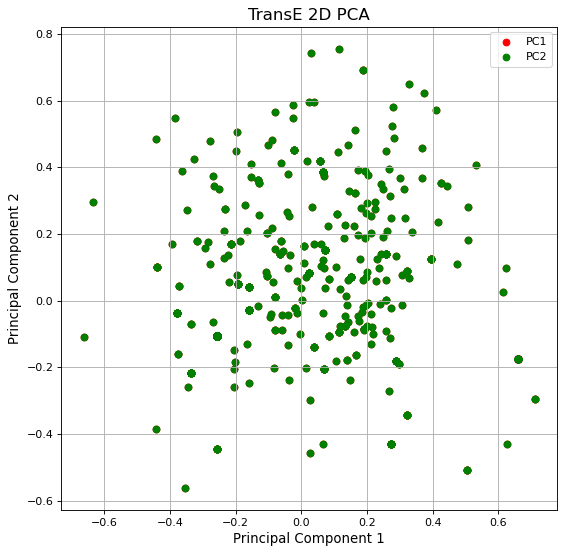

In [16]:
# PCA Plot
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

#classes = [1, 0]
colors = ['r', 'g']
for color in colors:
    plt.scatter(te_embed['ent1PC1'], 
                te_embed['ent1PC2'], 
                c = color)
    
plt.xlabel('Principal Component 1', fontsize = 12)
plt.ylabel('Principal Component 2', fontsize = 12)
plt.title('TransE-1 2D PCA', fontsize = 15)
plt.legend(['PC1', 'PC2'])
plt.grid()

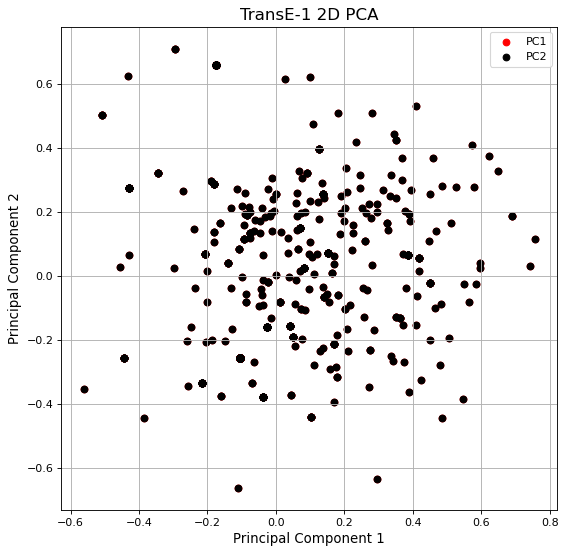

In [18]:
# PCA Plot
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

#classes = [1, 0]
colors = ['r', 'k']
for color in colors:
    plt.scatter(te_embed['ent1PC2'], 
                te_embed['ent1PC1'], 
                c = color)
    
plt.xlabel('Principal Component 1', fontsize = 12)
plt.ylabel('Principal Component 2', fontsize = 12)
plt.title('TransE-1 2D PCA', fontsize = 15)
plt.legend(['PC1', 'PC2'])
plt.grid()